## Test SPIM data CEBRA model

- Use CEBRA time contrastive learning on neural data from one fish, train decoder on eye position
    - design model
    - convert SPIM neural and data to usable format 
    - load data
    - fit
    - plot embeddings
    - try to decode eye position and compare it to the ElasticNet models
        - decoding of eye position (or tail vig) should work a lot better than stimulus response, because our discrete variables are very sparse
        - however, not training the model with any labels (self-supervised) will lead the generated embeddings only being dependent on temporal relations between  points (close timepoints considered as close in the path of embedding space). This embedding will then just use general temporal correlations in decoding, so that decoding eye position will be mainly from cells that correlate with visual or motor information, and not have particular weight on neurons controlling eye direction
        - should be using label contrastive learning for these datasets<br/><br/>



### Decoding eye position

In [14]:
import cebra
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split

In [15]:
# # global params

# list of all data files
dat_files = ['/media/storage/DATA/lfads_export/f1_221027.h5',
             '/media/storage/DATA/lfads_export/f1_221103.h5',
             '/media/storage/DATA/lfads_export/f2_221103.h5',
             '/media/storage/DATA/lfads_export/f3_221103.h5']

global FILENAME
global TIMESTEPS
global ROIS
global ITERS
global LOAD

FILENAME = dat_files[0]
TIMESTEPS = 15000
ROIS = 10000
ITERS = 10000
LOAD = False

In [16]:
# # Define model

cebra_time_model = cebra.CEBRA(
    model_architecture='offset10-model',
    device='cuda_if_available',
    conditional='time',
    temperature_mode='auto',
    min_temperature=0.1,
    time_offsets=10,
    max_iterations=ITERS,
    max_adapt_iterations=500,
    batch_size=1024,
    learning_rate=1e-4,
    output_dimension=3,
    verbose=True,
    num_hidden_units=32,
    hybrid=False
    )
print(cebra_time_model)

CEBRA(batch_size=1024, conditional='time', learning_rate=0.0001,
      model_architecture='offset10-model', output_dimension=3,
      temperature_mode='auto', time_offsets=10, verbose=True)


In [17]:
# # Load data for a single fish

# paths
filename = FILENAME
filename_trunc = filename.split('/')[-1][:-3] # fish and date only
data_folder = 'data/'
filename_eye_pos = f'{filename[-12:-3]}_eye_pos.npz'
filename_dfof = f'{filename[-12:-3]}_dfof.npz'

# choose where in dataset to sample
start, stop = 0, 0+TIMESTEPS

# extract eye position and neural data
# do not attempt to load the entire file 
print("Accessing data...")

# load data if it is already saved, and LOAD == True
if LOAD == True:
    try:
        eye_pos_l = cebra.load_data(f'{data_folder}{filename_eye_pos}', key="eye_pos_l")
        print(f"{filename_eye_pos}_left loaded.")
        eye_pos_r = cebra.load_data(f'{data_folder}{filename_eye_pos}', key="eye_pos_r")
        print(f"{filename_eye_pos}_right loaded.")
        neural = cebra.load_data(f'{data_folder}{filename_dfof}', key="neural")
        print(f"{filename_dfof} loaded.")
    
    except:
        pass
        print("Couldn't load data into CEBRA")

else:
    with h5py.File(filename, 'r') as f:

        # eye position
        eye_pos_l = f['visuomotor']['eye_pos']['Left']
        eye_pos_r = f['visuomotor']['eye_pos']['Right']
        print(f"Full eye position dataset shape is: {eye_pos_l.shape}")

        # neural 
        neural = f['rois']['dfof']
        print(f"Full neural dataset shape is: {neural.shape}")

        # select first TIMESTEPS timesteps and random ROIS rois
        # neural
        neural_indexes = np.sort(
                            np.random.choice(
                                        np.arange(neural.shape[1]), size=ROIS, replace=False
                                        )
                            )
        neural = np.array(neural[start:stop, neural_indexes])

        # eye position
        eye_pos_l = np.array(eye_pos_l[start:stop])
        eye_pos_r = np.array(eye_pos_r[start:stop])

        print(f"Truncated dataset shapes are:\n \
                eye_pos_l: {eye_pos_l.shape}\n \
                eye_pos_r: {eye_pos_r.shape}\n \
                neural: {neural.shape}")

        assert(neural.shape == (TIMESTEPS, ROIS))
        assert(eye_pos_l.shape) == (TIMESTEPS,)
        assert(eye_pos_r.shape) == (TIMESTEPS,)

        # save datasets
        np.savez(f'{data_folder}{filename_eye_pos}', eye_pos_l=eye_pos_l, eye_pos_r=eye_pos_r)
        np.savez(f'{data_folder}{filename_dfof}', neural=neural)

        # load datasets
        print("Data accessed.")
        eye_pos_l = cebra.load_data(f'{data_folder}{filename_eye_pos}', key="eye_pos_l")
        print(f"{filename_eye_pos}_left loaded.")
        eye_pos_r = cebra.load_data(f'{data_folder}{filename_eye_pos}', key="eye_pos_r")
        print(f"{filename_eye_pos}_right loaded.")
        neural = cebra.load_data(f'{data_folder}{filename_dfof}', key="neural")
        print(f"{filename_dfof} loaded.")

Accessing data...
Full eye position dataset shape is: (43350,)
Full neural dataset shape is: (43350, 93122)
Truncated dataset shapes are:
                 eye_pos_l: (15000,)
                 eye_pos_r: (15000,)
                 neural: (15000, 10000)
Data accessed.
f1_221027_eye_pos.npz_left loaded.
f1_221027_eye_pos.npz_right loaded.
f1_221027_dfof.npz loaded.


In [18]:
# Fit or load model
model_name = f"{filename_trunc}_time_{TIMESTEPS}points_{ROIS}rois_{ITERS}iters.pt"
model_path = f'models/{model_name}'

if LOAD and os.path.isfile(model_path):
    try:
        cebra_time_model = cebra.CEBRA.load(model_path)
        print("Model loaded.")
    except:
        print("Could not access model.")
else:
    cebra_time_model.fit(neural)
    cebra_time_model.save(model_path)
    print("Model fit and saved.")


pos:  0.0008 neg:  5.1969 total:  5.1977 temperature:  0.3530: 100%|██████████| 10000/10000 [16:27<00:00, 10.12it/s]


Model fit and saved.


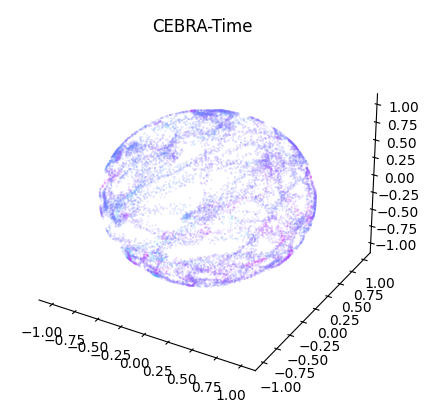

In [13]:
# # Create and plot model output

output_dims = 3

embedding = cebra_time_model.transform(neural)
cebra.plot_embedding(embedding, title='CEBRA-Time', cmap='cool', embedding_labels=eye_pos_l)


assert(embedding.shape == (TIMESTEPS, output_dims))

<Axes: xlabel='Steps', ylabel='Temperature'>

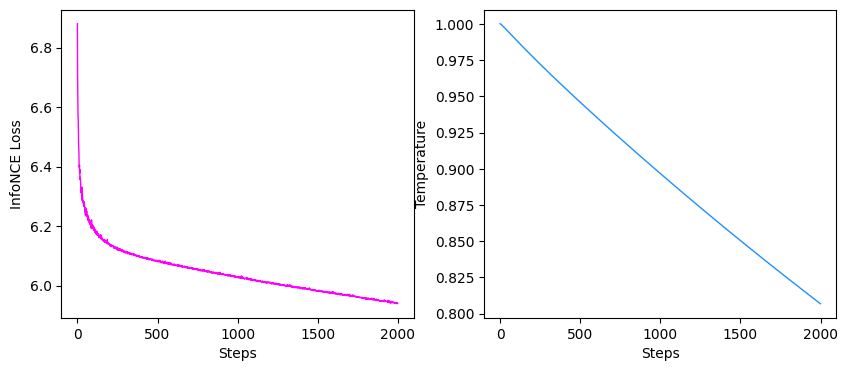

In [8]:
# # Visualise training loss and temperature
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

cebra.plot_loss(cebra_time_model, ax=ax1)
cebra.plot_temperature(cebra_time_model, ax=ax2)

In [9]:
# # Decode
decoder_l = cebra.KNNDecoder()
decoder_r = cebra.KNNDecoder()

# split data into train and test
(embedding_train, embedding_test,
 eye_pos_l_train, eye_pos_l_test,
 eye_pos_r_train, eye_pos_r_test)  = train_test_split(embedding, eye_pos_l, eye_pos_r, 
                                                      test_size=0.2, shuffle=False)

# train decoder
decoder_l.fit(embedding_train, eye_pos_l_train)
decoder_r.fit(embedding_train, eye_pos_r_train)

# get score and predictions
score_l = decoder_l.score(embedding_test, eye_pos_l_test)
score_r = decoder_r.score(embedding_test, eye_pos_r_test)

predictions_l = decoder_l.predict(embedding_test)
predictions_r = decoder_r.predict(embedding_test)




Text(0.5, 1.0, 'Right eye position predictions')

<Figure size 1000x800 with 0 Axes>

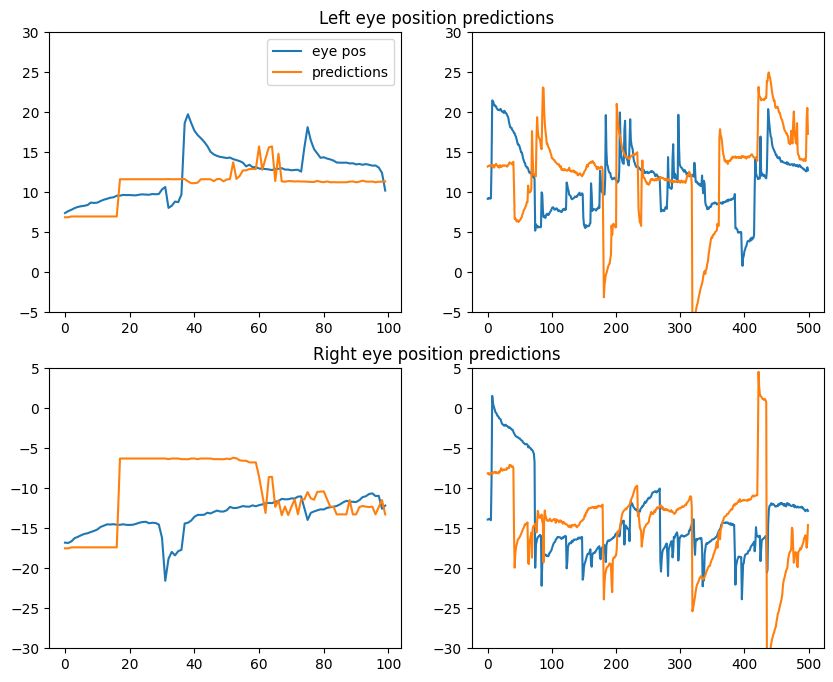

In [10]:
# # plot decoder prediction results 

fig = plt.figure(figsize=(10,8))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))

ax1.set_ylim(-5,30)
ax2.set_ylim(-5,30)
ax3.set_ylim(-30, 5)
ax4.set_ylim(-30, 5)

ax1.plot(eye_pos_l[-3000:-2900], label='eye pos')
ax1.plot(predictions_l[:100], label='predictions')
ax1.legend()

ax2.plot(eye_pos_l[-1000:-500], label='eye pos')
ax2.plot(eye_pos_l[2000:2500], label='predictions')


ax3.plot(eye_pos_r[-3000:-2900], label='eye pos')
ax3.plot(predictions_r[:100], label='predictions'), 


ax4.plot(eye_pos_r[-1000:-500], label='eye pos')
ax4.plot(eye_pos_r[2000:2500], label='predictions')

ax5 = fig.add_subplot(211, frameon=False)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_title("Left eye position predictions")

ax5 = fig.add_subplot(212, frameon=False)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_title("Right eye position predictions")


In [10]:
score_l, score_r

(-0.2681280145617393, -0.38559055709884715)